## Chapter 04 분류

In [1]:
import xgboost
print(xgboost.__version__)

0.90


## 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

-XGBoost의 파이썬 패키지인 xgboost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등 시각화 기능을 가지고 있음

-조기 중단 기능이 있음

-GBM과 다르게 병렬 처리와 조기 중단 등으로 빠른 수행시간 처리가 가능

-위스콘신 유방암 데이터 세트: 악성 종양인지 분류

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label =dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

#타깃 레이블의값의 종류는 maliganant가 0, benign이 1

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
#전체 데이터 중 80%는 학습용, 20%는 테스트용 데이터
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [6]:
#사이킷런과 큰 차이:학습용&테스트용 데이터셋을 위해 별도의 객체인 DMatrix 생성
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#파라미터
params = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'logloss', 'early_stoppings':100}
num_rounds = 400

In [8]:
#train 데이터 세트는 'train',evaluation(test) 데이터 세트는 'eval'로 명기합니다
wlist = [(dtrain, 'train'), (dtest, 'eval')]

#하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [9]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

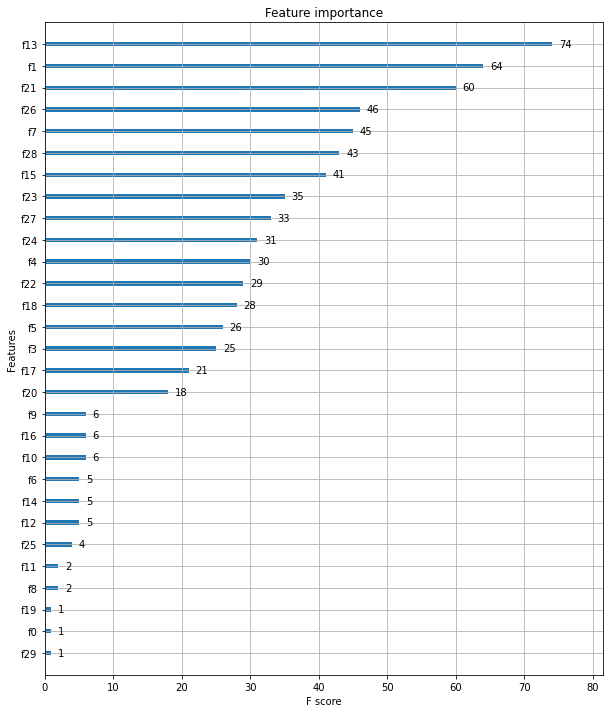

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax =plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [99]:
#앞으로는 파이썬 래퍼 XGBoost가 아닌 사이킷런 래퍼 XGBoost를 사용할 예정

## 사이킷런 래퍼 XGBoost의 개요 및적용

In [12]:
#분류를 위한 래퍼 클래스인 XGBClassifier를 이용해 예측
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [20]:
#get_clf_eval() 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델의 예측 성능 평가

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix

# 평가지표 출력하는 함수 설정  ***
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred)     
    precision = precision_score(y_test, pred)   
    recall = recall_score(y_test, pred)         
    f1 = f1_score(y_test, pred)                
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    
#테스트 실제 레이블값 가지는 y_test와 예측 레이블인 w_preds를 인자로 입력
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


In [22]:
#조기 중단
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learing_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [23]:
#조기중단으로 학습된 XGBClassifier의 예측성능
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


In [24]:
#10번 반복하는 동안 성능 평가 지표가 향상되지 않으면 조기 중단
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learing_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [25]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

#정확도가 0.9561로 stopping_rounds=100일 때의 약 0.9649보다 낮음 

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9947


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

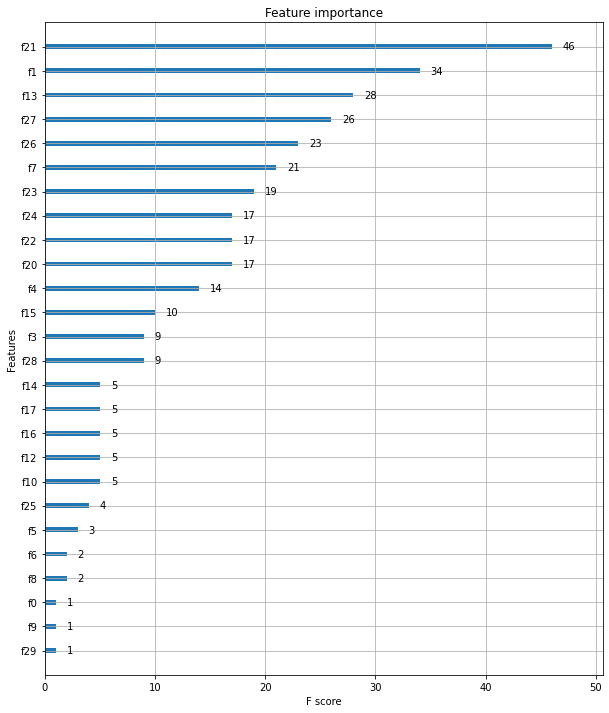

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## LightGBM

-Xgboost보다 학습 시간이 훨씬 적고 메모리 사용량도 상대적으로 적음

-BUT 적은 데이터 세트에 적용 시 과적합 발생 쉬움

## LightGBM 적용 - 위스콘신 유방암 예측

In [29]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

#전체 데이터 중 80%는 학습, 20%는 테스트용 데이터
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba =lgbm_wrapper.predict_proba(X_test)[:,1] #predict_proba의 출력은 각 클래스에 대한 확률

#조기중단으로 145번 반복까지만 수행하고 학습 종료

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [28]:
get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC: 0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

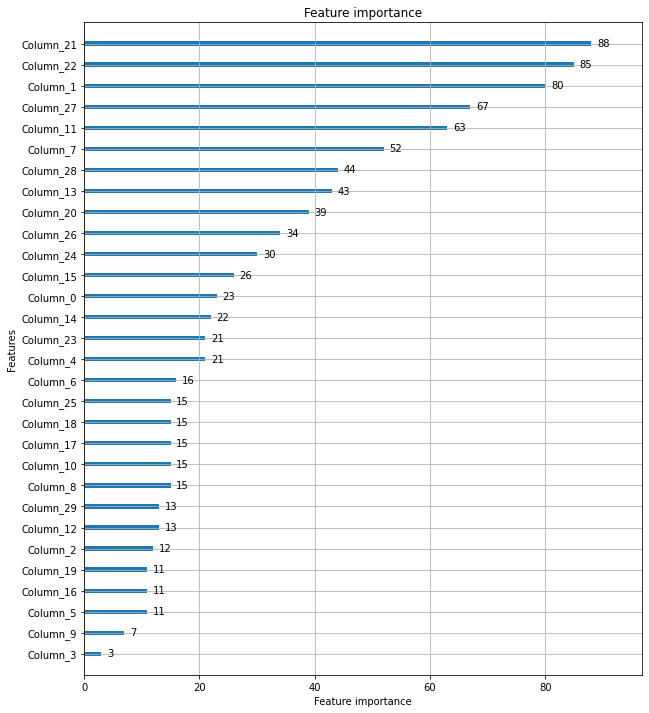

In [30]:
#plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## 08 분류 실습 - 캐글 산탄데르 고객 만족 예측
-고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측

-모델의 성능 평가는 ROC-AUC로 평가함

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [106]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [107]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [108]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [109]:
#-999999를 2로 바꾸기

cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

#피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [111]:
#XGBoost 모델 학습과 하이퍼 파라미터 튜닝
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

In [112]:
#XGBoost의 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}


#cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", 
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

GridSearchCV에서 재학습된 Estimator에서 ROC-AUC 수치가 어떻게 향상됐는지 확인:
    
    하이퍼 파라미터 적용한 후 0.8448로 조금 개선됨

In [113]:
#앞에서 구한 최적화 하이퍼 파라미터를 기반으로 다른 하이퍼 파라미터를 변경 또는 추가해 최적화 진행

#n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                       min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

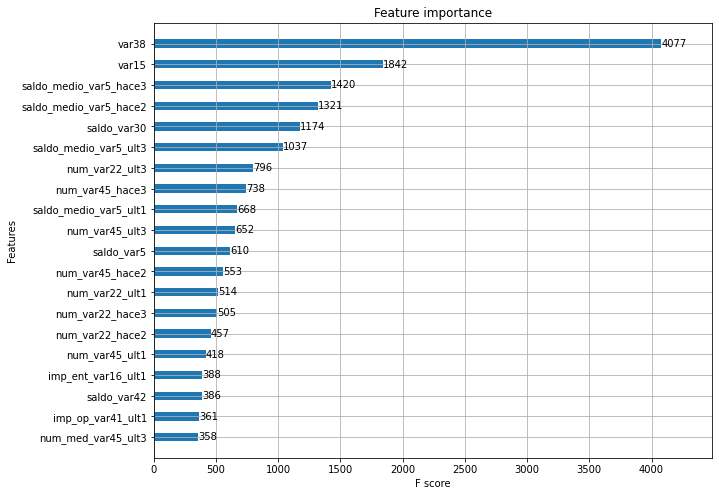

In [114]:
#plot_importance() 메서드로 그래프 그리기
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [115]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

LightGBM이 XGBoost보다 학습에 걸리는 시간이 좀 더 단축됨

In [116]:
#파라미터 튜닝
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64], 
         'max_depth': [128, 160], 
         'min_child_samples': [60, 100], 
         'subsample': [0.8, 1]}

#cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average="macro")
print('ROC AUC: {0.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

AttributeError: 'numpy.float64' object has no attribute '4f'

In [117]:
#파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100, max_depth=128)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: sumbsample
[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	v

## 09 분류 실습 - 캐글 신용카드 사기 검출

### 언더 샘플링과 오버 샘플링의 이해

지도학습에서 극도로 불균형한 레이블값 분포로 인한 문제점을 해결하기 위한 방안들

-언더 샘플링: 많은 데ㅔ이터 세트를 적은 데이터 세트 수준으로 감소

-오버 샘플링: 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보. SMOTE 방법 등을 이용해서 원본 데이터의 피처 값들을 약간만 변경하여 증식

## 데이터 일차 가공 및 모델 학습/예측/평가

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [119]:
from sklearn.model_selection import train_test_split

#인자로 입력된 df를 복사한 뒤 각공하여 변환하는 함수
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [120]:
#데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수
def get_train_test_dataset(df=None):
    #인자로 입력된 df의 사전 데이터 가공이 완료된 복사 df 반환
    df_copy = get_preprocessed_df(df)
    #df의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:, -1]
    #train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    #학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [121]:
#비슷하게 분할됐는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [122]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]


#get_clf_eval() 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델의 예측 성능 평가

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix

# 평가지표 출력하는 함수 설정  ***
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred)     
    precision = precision_score(y_test, pred)   
    recall = recall_score(y_test, pred)         
    f1 = f1_score(y_test, pred)                
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    
#3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85282    13]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8700, 재현율: 0.5878, F1: 0.7016, AUC: 0.9600


In [123]:
#인자로 사이킷런의 Estimator 객체의 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [124]:
#LightGBM으로 모델 학습 뒤 별도의 테스트 데이터 세트에서 예측 평가 수행
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

#로지스틱 회귀보다 높은 수치 보임

오차행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


## 데이터 분포도 변환 후 모델 학습/예측/평가

-왜곡된 분포도를 가지는 데이터를 재가공 뒤 모델 다시 테스트

-중요 피처값의 분포도 확인

-로지스틱 회귀는 선형 모델. 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호.

-Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성

<AxesSubplot:xlabel='Amount', ylabel='Density'>

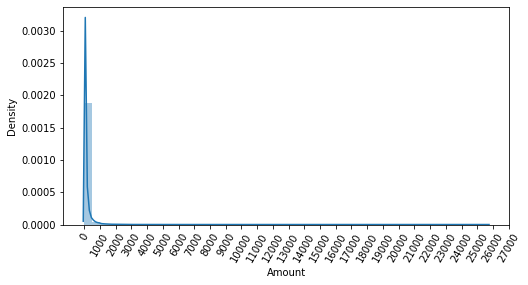

In [125]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [126]:
#Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    #변환된 Amount를 Amount_Scaled로 피처명을 변경 후 DF 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    #기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [127]:
#학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
오차행렬
[[85248    47]
 [   69    79]]
정확도: 0.9986, 정밀도: 0.6270, 재현율: 0.5338, F1: 0.5766, AUC: 0.7666


In [128]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    #넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [129]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

#정밀도, 재현율, ROC-AUC에서 약간씩 성능이 개선됨

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차행렬
[[85174   121]
 [  148     0]]
정확도: 0.9969, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC: 0.4992


## 이상치 데이터 제거 후 모델 학습/예측/평가

<AxesSubplot:>

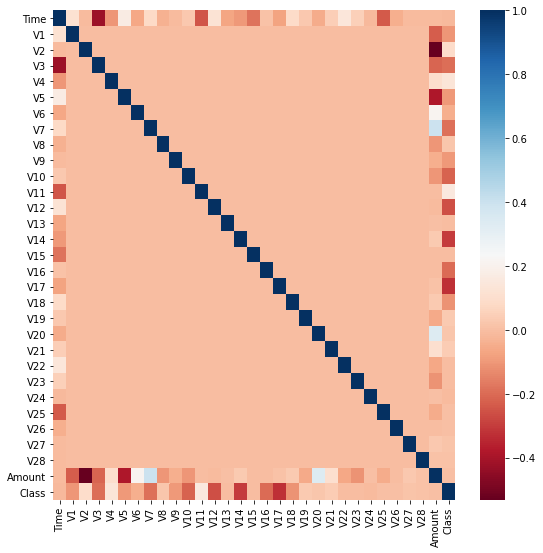

In [130]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

-상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현됨

-Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17임

-이 중 V14에 대해서만 이상치를 찾음

In [131]:
#IQR을 이용해 이상치를 검출하는 함수 생성 뒤 검출된 이상치를 삭제
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    hightest_val = quantile_75 + iqr_weight
    #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 df index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > hightest_val)].index
    return outlier_index

In [132]:
#get_outlier() 함수를 이용해 V14 칼럼에서 이상치 데이터를 찾음
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [133]:
#get_outlier()를 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델을 다시 적용
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    #이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534, F1: 0.7774, AUC: 0.9219


In [134]:
## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)


In [135]:
print('SMOTE 적용 후 학습용 피터/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 후 학습용 피터/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


SMOTE 적용 전에는 199,362건 -> 적용 후 2배 가까운 398040건

In [136]:
lr_clf = LogisticRegression()

#ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


로지스틱 회귀 모델의 경우 SMOTE로 정밀도가 급격하게 저하.

이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격하게 떨어진 것.

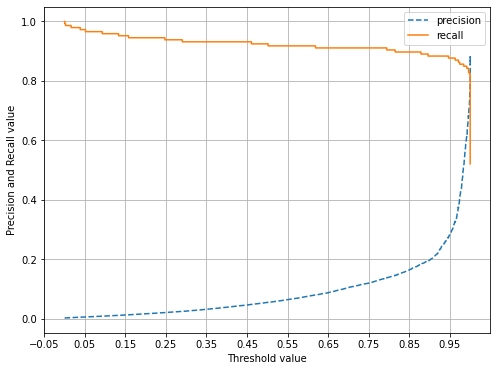

In [137]:
from sklearn.metrics import precision_recall_curve

# 정밀도 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축:threshold값, Y축:정밀도, 재현율, 정밀도:점선
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()    
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))   
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()   
    plt.show()

    
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐

In [138]:
#LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC: 0.9814


SMOTE를 적용하면 재현율은 높아지나 정밀도는 낮아짐

좋은 SMOTE 패키지일수록 재현율 증가율은 높이고, 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터 증식

## 10 스태킹 앙상블

스태킹: 개별적 여러 알고리즘을 서로 결합해 예측 결과 도출(배깅 및 부스팅과 공통점)
    
    -BUT 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행
    -두 종류의 모델 필요: 1. 개별적인 기반 모델, 2. 최종 메타 모델
    -스태킹 형태로 진행

### 기본 스태킹 모델

In [139]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [140]:
#스태킹에 사용될 머신러닝 알고리즘 클래스
#최종 모델은 로지스틱 회귀

#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [141]:
#개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [142]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_clf = GradientBoostingClassifier(random_state = 0)
gbm_clf.fit(X_train, y_train)

#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
gbm_pred = gbm_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [143]:
#개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙어서 피처값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용

pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [144]:
#예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9649


## CV 세트 기반의 스태킹
-과적합 개선 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용

In [145]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터 
    return train_fold_pred, test_pred_mean

In [146]:
#여러 개의 분류 모델 별로 stack_base_model() 함수를 수행
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [147]:
#스텝 2
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [148]:
'''
Stack_final_X_train: 메타 모델이 핛브할 학습용 피처 데이터 세트
Stack_final_X_test: 메타 모델이 예측할 테스트용 피처 데이터 세트
'''
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

#스태킹을 이루는 모델은 최적으로 파라미터를 튜닝한 상태에서 스태킹 모델을 만드는 것이 일반적

최종 메타 모델의 예측 정확도: 0.9737
